In [0]:
from google.colab import files
import json
from glob import glob
import fnmatch
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, Input, add
from keras import Sequential
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model


Reading the 0 and 1 class urls separately using glob. 

In [0]:
class0_images = glob('/content/*/0/*.png', recursive=True)
class1_images = glob('/content/*/1/*.png', recursive=True)

## Model without residual connections

Reading a sub sample of class 0 images and re -sizing them with height and width=50.  The images are read in X and the labels in Y. The same process is repeated for class 1 images. 

All the images have to be of the same size , hence the resizing is necessary. 

As the data is unbalanced, I am manually sampling equal number of data points from each class. As we are balancing the data at the start, accuracy is considered as an evaluation metric.

In [0]:
x = []
y = []
WIDTH = 50
HEIGHT = 50

for img in class0_images[0:3000]:
    full_size_image = cv2.imread(img)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                      interpolation=cv2.INTER_CUBIC))
    y.append(0)
    
for img in class1_images[0:3000]:
    full_size_image = cv2.imread(img)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                      interpolation=cv2.INTER_CUBIC))
    y.append(1)

Preprocessing of images:
Dividing image by 255 for standarization. 
We could also transform the images from RGB to gray scale. 

Dividing the images into train and test with stratified sampling. So the distribution across train and test remain the same

In [20]:
X=np.array(x)
X = X/255

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,stratify = y)



print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (4800, 50, 50, 3)
Testing Data Shape: (1200, 50, 50, 3)


Defining the neural network:
For simplicity of the problem I have kept 2 convolution layers with  kernel_size (3,3), followed by batch normalization ,Max pooling of (2,2) and Dropout. 

The drop out parameter , Max pool size can be tuned but due to restriction of computational resources , we are unable to. The same can be said for kernel size.

Train on 4320 samples, validate on 480 samples
Epoch 1/30
 - 1s - loss: 1.3574 - acc: 0.6037 - val_loss: 0.6067 - val_acc: 0.7667
Epoch 2/30
 - 0s - loss: 0.8627 - acc: 0.7072 - val_loss: 0.5114 - val_acc: 0.7896
Epoch 3/30
 - 0s - loss: 0.6473 - acc: 0.7708 - val_loss: 0.7324 - val_acc: 0.7396
Epoch 4/30
 - 0s - loss: 0.5772 - acc: 0.7875 - val_loss: 0.4432 - val_acc: 0.8313
Epoch 5/30
 - 0s - loss: 0.5275 - acc: 0.7970 - val_loss: 0.7288 - val_acc: 0.7042
Epoch 6/30
 - 0s - loss: 0.4587 - acc: 0.8148 - val_loss: 0.5445 - val_acc: 0.7875
Epoch 7/30
 - 0s - loss: 0.4108 - acc: 0.8333 - val_loss: 0.4240 - val_acc: 0.8375
Epoch 8/30
 - 0s - loss: 0.3861 - acc: 0.8461 - val_loss: 0.4129 - val_acc: 0.8354
Epoch 9/30
 - 0s - loss: 0.3724 - acc: 0.8553 - val_loss: 0.3990 - val_acc: 0.8438
Epoch 10/30
 - 0s - loss: 0.3457 - acc: 0.8650 - val_loss: 0.4172 - val_acc: 0.8250
Epoch 11/30
 - 0s - loss: 0.3400 - acc: 0.8625 - val_loss: 0.4786 - val_acc: 0.8208
Epoch 12/30
 - 0s - loss: 0.3421 - acc

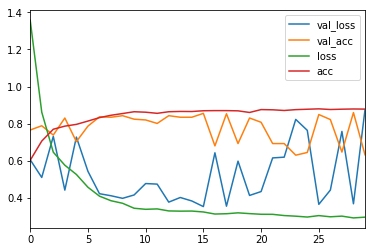

In [27]:

num_classes = 2
input_shape = (50, 50, 3)


cnn_small_bn = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(.5),
    Conv2D(8, kernel_size = (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(.5),
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])

y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

cnn_small_bn.compile("adam", "binary_crossentropy", metrics=['accuracy'])
history_cnn = cnn_small_bn.fit(X_train, y_train,
                      batch_size=128, epochs=30, verbose=2, validation_split=.1)
pd.DataFrame(history_cnn.history).plot()


The model performs pretty well on train dataset but not that great on validation dataset. There are some spikes in validation loss seen from the graph, which suggests that the validation does not give stable results with the architecture.

## Model with Data Augmentation

In [0]:
import os
import shutil

for file in class0_images[:3000]:
    shutil.copy(file, '/content/data/0/')

for file in class1_images[:3000]:
    shutil.copy(file, '/content/data/1/')  


We are applied here different types of data transformations:
1. Scaling the data
2. Sheer mapping the images
3. Zooming the images
4. Horizontal Flip
5. Data Rotation by 50 degrees
6. Fraction of height of original image shifted

Then we train the same neural achitecture as defined in task 3.1 using the augmented dataset.

Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Epoch 1/30
 - 0s - loss: 0.4078 - acc: 0.8229 - val_loss: 0.3139 - val_acc: 0.8906
Epoch 2/30
 - 0s - loss: 0.2991 - acc: 0.8854 - val_loss: 0.3061 - val_acc: 0.8438
Epoch 3/30
 - 0s - loss: 0.3463 - acc: 0.8698 - val_loss: 0.3072 - val_acc: 0.8594
Epoch 4/30
 - 0s - loss: 0.3320 - acc: 0.8646 - val_loss: 1.4210 - val_acc: 0.6094
Epoch 5/30
 - 0s - loss: 0.3079 - acc: 0.8333 - val_loss: 1.4040 - val_acc: 0.5625
Epoch 6/30
 - 0s - loss: 0.4024 - acc: 0.8438 - val_loss: 1.0080 - val_acc: 0.6562
Epoch 7/30
 - 0s - loss: 0.4242 - acc: 0.8177 - val_loss: 0.8240 - val_acc: 0.6875
Epoch 8/30
 - 0s - loss: 0.3027 - acc: 0.8958 - val_loss: 0.3631 - val_acc: 0.8594
Epoch 9/30
 - 0s - loss: 0.3673 - acc: 0.8281 - val_loss: 0.6636 - val_acc: 0.7344
Epoch 10/30
 - 0s - loss: 0.3515 - acc: 0.8646 - val_loss: 0.3644 - val_acc: 0.7812
Epoch 11/30
 - 0s - loss: 0.4436 - acc: 0.8125 - val_loss: 0.3304 - val_acc: 0.8125
E

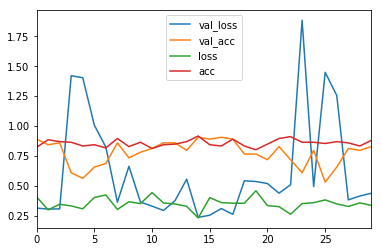

In [36]:
batch_size=32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        rotation_range=50,
        height_shift_range=0.1,validation_split=0.1)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/data/',  # this is the target directory
        target_size=(50, 50),  # all images will be resized to 50x50
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/content/data/',
        target_size=(50, 50),
        batch_size=batch_size,
        class_mode='categorical')


history_cnn = cnn_small_bn.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=30,
        verbose=2,
        validation_data=validation_generator,
        validation_steps=80 // batch_size)

pd.DataFrame(history_cnn.history).plot()


Now we compare the original model in Task 3.1, with the model trained on augmented data. The model performs really well on validation dataset as compared to original model (from 0.63 to 0.82). Even we have managed to increase the training set accuracy (0.87 to 0.88).

### Deeper Model without Residual Connections

We have made an architecture for Convolution Neural Network with 20 layers, where in the last layer we have added dropout and batch normalization as well. 

In [0]:
cnn_without_resid = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),
    
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),
    
    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),

    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),
    
    Conv2D(8, kernel_size = (3,3), activation='relu', padding='same'),
    
    BatchNormalization(),
    
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.3),
    
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])


In [0]:
cnn_without_resid.compile("adam", "binary_crossentropy", metrics=['accuracy'])

Epoch 1/30
 - 1s - loss: 0.3663 - acc: 0.8438 - val_loss: 1.4415 - val_acc: 0.3906
Epoch 2/30
 - 0s - loss: 0.4282 - acc: 0.8438 - val_loss: 0.8633 - val_acc: 0.5469
Epoch 3/30
 - 0s - loss: 0.4351 - acc: 0.7930 - val_loss: 1.2402 - val_acc: 0.4531
Epoch 4/30
 - 0s - loss: 0.4093 - acc: 0.7969 - val_loss: 0.9485 - val_acc: 0.5469
Epoch 5/30
 - 0s - loss: 0.4392 - acc: 0.8281 - val_loss: 1.2128 - val_acc: 0.4531
Epoch 6/30
 - 0s - loss: 0.4204 - acc: 0.8385 - val_loss: 0.4814 - val_acc: 0.8125
Epoch 7/30
 - 0s - loss: 0.4396 - acc: 0.8490 - val_loss: 0.4905 - val_acc: 0.7812
Epoch 8/30
 - 0s - loss: 0.4058 - acc: 0.8385 - val_loss: 0.9501 - val_acc: 0.6094
Epoch 9/30
 - 0s - loss: 0.4390 - acc: 0.7917 - val_loss: 0.7679 - val_acc: 0.4688
Epoch 10/30
 - 0s - loss: 0.4146 - acc: 0.8542 - val_loss: 0.4204 - val_acc: 0.8281
Epoch 11/30
 - 0s - loss: 0.4343 - acc: 0.8229 - val_loss: 0.9920 - val_acc: 0.5312
Epoch 12/30
 - 0s - loss: 0.3856 - acc: 0.8594 - val_loss: 1.1524 - val_acc: 0.4219
E

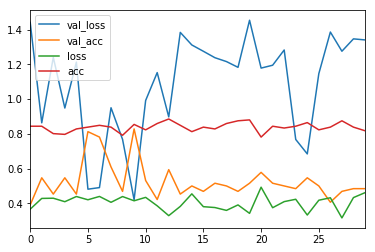

In [101]:
cnn_hist_noResid = cnn_without_resid.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        verbose=2,
        validation_steps=80 // batch_size)

pd.DataFrame(cnn_hist_noResid.history).plot()

The deeper model without residual connections, performs quite well on training dataset but does performs poorly on validation dataset.

### Deeper Model with Residual Connections

In [0]:
inputs = Input(shape=input_shape)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(inputs)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x1 = MaxPooling2D(pool_size=(2, 2))(x)
x2 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x1)
x2 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x2)
x2 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x2)
x2 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x2)
skip1 = add([x1,x2])
x = MaxPooling2D(pool_size=(2, 2))(skip1)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x3 = MaxPooling2D(pool_size=(2, 2))(x)
x4 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x3)
x4 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x4)
x4 = BatchNormalization()(x4)
skip2 = add([x3,x4])
x = MaxPooling2D(pool_size=(2, 2))(skip2)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)
cnn_with_resid = Model(inputs=inputs, outputs=predictions)
cnn_with_resid.compile("adam", "binary_crossentropy", metrics=['accuracy'])

Epoch 1/30
 - 1s - loss: 0.3687 - acc: 0.8646 - val_loss: 0.7818 - val_acc: 0.6094
Epoch 2/30
 - 0s - loss: 0.4034 - acc: 0.8229 - val_loss: 1.2800 - val_acc: 0.5469
Epoch 3/30
 - 0s - loss: 0.3278 - acc: 0.8906 - val_loss: 0.7255 - val_acc: 0.6406
Epoch 4/30
 - 0s - loss: 0.3831 - acc: 0.8438 - val_loss: 0.3030 - val_acc: 0.8906
Epoch 5/30
 - 0s - loss: 0.4733 - acc: 0.8177 - val_loss: 0.3243 - val_acc: 0.8594
Epoch 6/30
 - 0s - loss: 0.3464 - acc: 0.8750 - val_loss: 0.4152 - val_acc: 0.8125
Epoch 7/30
 - 0s - loss: 0.4105 - acc: 0.7969 - val_loss: 0.4075 - val_acc: 0.8125
Epoch 8/30
 - 0s - loss: 0.3439 - acc: 0.8438 - val_loss: 0.4663 - val_acc: 0.7812
Epoch 9/30
 - 0s - loss: 0.3490 - acc: 0.8698 - val_loss: 0.3756 - val_acc: 0.8438
Epoch 10/30
 - 0s - loss: 0.4095 - acc: 0.8542 - val_loss: 0.4881 - val_acc: 0.7969
Epoch 11/30
 - 0s - loss: 0.3755 - acc: 0.8438 - val_loss: 0.2495 - val_acc: 0.9062
Epoch 12/30
 - 0s - loss: 0.3747 - acc: 0.8698 - val_loss: 1.2437 - val_acc: 0.5156
E

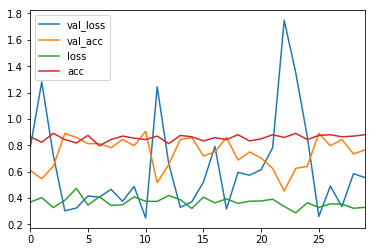

In [82]:
cnn_hist_withResid = cnn_with_resid.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=30,
        verbose=2,
        validation_data=validation_generator,
        validation_steps=80 // batch_size)

pd.DataFrame(cnn_hist_withResid.history).plot()

Now we compare the two deep models and observe that, the performance of model on validation dataset increases by considerable amount. The accuracy on training dataset has also increased. This suggests that after residual connections, the model performs much better as compared to the model without residual connections.